# Inference in Bayesian Networks - Cardiovascular Disease Dataset

**Group Number:** 14  
**Student Names:** Andrea Fruttidoro (66373); Pedro Fanica (54346); Quentin WEISS (66292);

---
---


## 0.&nbsp;Useful Tools

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.inference import BeliefPropagation
from pgmpy.factors.discrete import TabularCPD
from IPython.display import display
import networkx as nx
import re
from sklearn.metrics import mutual_info_score

In [4]:
# =============================================================================
# UTILITY FUNCTIONS
# =============================================================================

def summarize_missing(df):
    """
    Summarize missing values in the dataset.

    Returns
    -------
    summary : pd.DataFrame or None
        DataFrame with column, dtype, count of missing values,
        % missing, and column type classification.
        Returns None if no missing values.
    """
    total_rows = len(df)
    missing_info = (
        df.isnull()
        .sum()
        .reset_index()
        .rename(columns={"index": "column", 0: "missing_count"})
    )
    missing_info["missing_pct"] = (missing_info["missing_count"] / total_rows) * 100

    # Filter only columns with missing values
    summary = missing_info[missing_info["missing_count"] > 0].reset_index(drop=True)

    if summary.empty:
        print("✅ No missing values detected.")
        return None
    else:
        print("Missing values detected:")
        return summary

def custom_impute(df, num_cols, cat_cols, col_to_group=None, verbose=False):
    """
    Impute missing values using local context (values before and after each NaN).

    - Numeric: linear interpolation between previous & next values; edges filled with ffill/bfill
    - Categorical: forward-fill then back-fill (last known value)

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    num_cols : list
        List of numeric columns to impute.
    cat_cols : list
        List of categorical columns to impute.
    col_to_group : str or None, optional
        Column name to group by (e.g., patient ID). If None, no grouping is applied.
    verbose : bool, default False
        If True prints counts of filled values per column.

    Returns
    -------
    pd.DataFrame
        DataFrame with imputed values (same index/order as input).
    """
    df = df.copy()

    def impute_group(group):
        g = group.copy()

        # Numeric columns: interpolate then forward/back fill
        for col in num_cols:
            if col in g.columns:
                before_na = g[col].isna().sum()
                if before_na > 0:
                    # try numeric interpolation (works only for numeric dtype)
                    try:
                        g[col] = g[col].interpolate(method='linear', limit_direction='both')
                    except Exception:
                        # fallback: do not crash if non-numeric
                        pass

                    # fill edge NaNs
                    g[col] = g[col].ffill().bfill()

                    if verbose:
                        after_na = g[col].isna().sum()
                        filled = before_na - after_na
                        print(f"[group {g.name if hasattr(g, 'name') else ''}] Filled {filled} NaNs in numeric column '{col}'")

        # Categorical columns: forward-fill then back-fill
        for col in cat_cols:
            if col in g.columns:
                before_na = g[col].isna().sum()
                if before_na > 0:
                    g[col] = g[col].ffill().bfill()
                    if verbose:
                        after_na = g[col].isna().sum()
                        filled = before_na - after_na
                        print(f"[group {g.name if hasattr(g, 'name') else ''}] Filled {filled} NaNs in categorical column '{col}'")

        return g

    # Apply grouped or global imputation
    if col_to_group:
        # Try the pandas>=2.2 concise call first (silences future deprecation)
        try:
            res = df.groupby(col_to_group, group_keys=False, include_groups=False).apply(impute_group)
            # ensure same row order as original
            res = res.loc[df.index]
            return res
        except TypeError:
            # include_groups not supported in this pandas version -> fallback to manual loop (no warning)
            parts = []
            # preserve grouping order by iterating groupby(sort=False)
            for _, grp in df.groupby(col_to_group, sort=False):
                parts.append(impute_group(grp))
            res = pd.concat(parts)
            # reindex to original order (important)
            res = res.loc[df.index]
            return res
    else:
        # No grouping: just operate on full dataframe
        res = impute_group(df)
        return res


def estimate_cpt(df, child, parents, laplace=1):
    child_states = sorted(df[child].dropna().unique().tolist())
    parents_states = [sorted(df[p].dropna().unique().tolist()) for p in parents]
    parent_combos = list(product(*parents_states)) if parents else [()]

    counts = {}
    for combo in parent_combos:
        if parents:
            mask = np.logical_and.reduce([(df[p] == v) for p,v in zip(parents, combo)])
            sub = df[mask]
        else:
            sub = df
        c = sub[child].value_counts().reindex(child_states, fill_value=0).astype(float)
        c = c + laplace  # lissage de Laplace
        probs = (c / c.sum()).values
        counts[combo] = probs

    cpt_matrix = np.column_stack([counts[combo] for combo in parent_combos])
    return child_states, parents_states, cpt_matrix

def cmi_discrete(df, x, y, given):
    """
    Calculates the Conditional Mutual Information (CMI) between two discrete variables x and y, given a set of variables 'given'.
    CMI(X;Y|Z) = sum_{z} P(z) * I(X;Y|Z=z)
    This is approximated by taking the weighted average of the mutual information
    across each subgroup defined by the conditioning variables 'given'.

    Args:
        df (pd.DataFrame): The dataframe containing the data.
        x (str): The name of the first variable.
        y (str): The name of the second variable.
        given (list of str): A list of variable names to condition on.

    Returns:
        float: The calculated Conditional Mutual Information.
    """
    if not given:
        # If there are no conditioning variables, return standard Mutual Information
        return mutual_info_score(df[x], df[y])

    # Group the dataframe by the conditioning variables
    groups = df.groupby(given)
    total_rows = len(df)
    cmi = 0.0

    # Iterate over each group (each unique combination of the 'given' variables)
    for _, group_df in groups:
        if len(group_df) > 1:
            # Weight is the probability of this combination of 'given' variables
            weight = len(group_df) / total_rows
            # Add the weighted mutual information of the subgroup to the total
            cmi += weight * mutual_info_score(group_df[x], group_df[y])

    return cmi

## 1.&nbsp;Introduction
The main goal is to use the BN model to calculate posterior probabilities (inference) to support clinical decision-making under uncertainty. This involves answering key questions regarding:

* Diagnosis➞($P(\text{state}|\text{chest_pain, fatigue})$);

* Treatment➞($P(\text{treatment}|\text{chest_pain, fatigue})$);

* Outcomes➞($P(\text{utility}|\text{risk}, \text{treatment})$).

We will compare the results of exact inference and approximate inference to evaluate their accuracy and computational efficiency.

The two primary methods for exact computation are:

1. Variable Elimination (VE): This algorithm efficiently performs the marginalization by systematically summing out the hidden variables one at a time, exploiting the conditional independence encoded in the network to avoid computing the full joint distribution.

2. Belief Propagation (BP): This method propagates probability "messages" between nodes in the network. It is particularly efficient for tree-structured networks and delivers the exact posterior distribution.

## 2.&nbsp;Preprocessing and Discretization

In [5]:
#Load the datasets
patients=pd.read_csv('patients.csv', sep=';')
encounters=pd.read_csv('encounters.csv', sep=';')

# Handle missing treatment values
encounters['treatment'] = encounters['treatment'].fillna('None')
encounters.head()

,patient_id,time,state,treatment,chest_pain,fatigue,shortness_of_breath,systolic_bp,cholesterol,glucose,troponin,utility
0,1,0,Early,DrugA,1.0,1.0,0.0,113.68,NaN,88.58,NaN,0.449
1,1,1,Early,Lifestyle,0.0,NaN,0.0,130.60,226.68,112.56,0.0139,0.471
2,1,2,Early,None,NaN,0.0,0.0,165.78,146.18,95.92,0.0234,0.474
3,1,3,Early,DrugA,0.0,1.0,0.0,NaN,179.56,108.17,0.0141,0.450
4,1,4,Early,DrugA,NaN,0.0,0.0,143.03,NaN,NaN,0.0033,0.447


In [6]:
# ---------- 1. Select features for NaNs imputation ----------
symptoms = ["chest_pain", "fatigue", "shortness_of_breath"]
treatment_var = ["treatment"]
labs = ["systolic_bp", "cholesterol", "glucose", "troponin"]
selected = symptoms + labs + treatment_var

# ---------- 2. Apply imputation strategy  ----------
df_transf = custom_impute(encounters, labs, symptoms, col_to_group="patient_id")

summarize_missing(df_transf)

✅ No missing values detected.


In [7]:
merged_df = df_transf.merge(patients, on='patient_id', how='left')

print(merged_df.shape)

(24000, 20)


In [8]:
labs = ['systolic_bp', 'cholesterol', 'glucose', 'troponin']

df_discrete = merged_df.copy()

# discretize the labs in two categories
for col in labs:
    mean_value = merged_df[col].mean()
    df_discrete[col + '_cat'] = merged_df[col].apply(lambda x: 'High' if x > mean_value else 'Low')

# remove the orignial numeric variables
df_discrete = df_discrete.drop(columns=labs)

print(df_discrete.head())

# Compute absolute and relative frequencies for each new categorical variable
for col in labs:
    cat_col = col + '_cat'
    print(f"\nDistribution of '{cat_col}':")

    # Absolute frequencies
    abs_freq = df_discrete[cat_col].value_counts()
    # Relative frequencies
    rel_freq = df_discrete[cat_col].value_counts(normalize=True)

    # Combine both in one table
    dist = pd.DataFrame({
        'Absolute Frequency': abs_freq,
        'Relative Frequency': rel_freq.round(3)
    })

    print(dist)


   patient_id  time  state  treatment  chest_pain  fatigue  \
0           1     0  Early      DrugA         1.0      1.0   
1           1     1  Early  Lifestyle         0.0      1.0   
2           1     2  Early       None         0.0      0.0   
3           1     3  Early      DrugA         0.0      1.0   
4           1     4  Early      DrugA         0.0      0.0   

   shortness_of_breath  utility  age sex    bmi  smoker  family_history  \
0                  0.0    0.449   61   M  26.05       0               0   
1                  0.0    0.471   61   M  26.05       0               0   
2                  0.0    0.474   61   M  26.05       0               0   
3                  0.0    0.450   61   M  26.05       0               0   
4                  0.0    0.447   61   M  26.05       0               0   

   hypertension  risk_score initial_state systolic_bp_cat cholesterol_cat  \
0             0           1         Early             Low            High   
1             0       

In [9]:
# Define the thresholds
bins = [-float('inf'), 0.2, 0.75, float('inf')]
labels = ['Low', 'Medium', 'High']

# Create the categorical variable
df_discrete['utility_cat'] = pd.cut(df_discrete['utility'], bins=bins, labels=labels)

# Frequency table: absolute counts and percentages
utility_counts = df_discrete['utility_cat'].value_counts()
utility_percent = df_discrete['utility_cat'].value_counts(normalize=True) * 100

# Combine into one DataFrame
utility_dist = pd.DataFrame({
    'Count': utility_counts,
    'Percentage (%)': utility_percent.round(2)
})

print(utility_dist)

             Count  Percentage (%)
utility_cat                       
High         15171           63.21
Medium        7655           31.90
Low           1174            4.89


## 3.&nbsp;Discrete Bayesian Network

In [10]:
# Define the edges of the Bayesian Network (DAG)
edges = [
    ('risk_score', 'state'),

    ('state', 'chest_pain'),
    ('state', 'fatigue'),
    ('state', 'shortness_of_breath'),
    ('state', 'systolic_bp_cat'),
    ('state', 'glucose_cat'),
    ('state', 'cholesterol_cat'),
    ('state', 'troponin_cat'),

    # State -> Treatment
    ('state','treatment'),

    # Clinical -> Treatment
    ('chest_pain', 'treatment'),
    ('fatigue', 'treatment'),
    ('shortness_of_breath', 'treatment'),
    ('systolic_bp_cat', 'treatment'),
    ('glucose_cat', 'treatment'),
    ('cholesterol_cat', 'treatment'),
    ('troponin_cat', 'treatment'),

    ('state','utility_cat'),
    ('treatment', 'utility_cat')
]

model = DiscreteBayesianNetwork(edges)

/tmp/ipython-input-3640122686.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


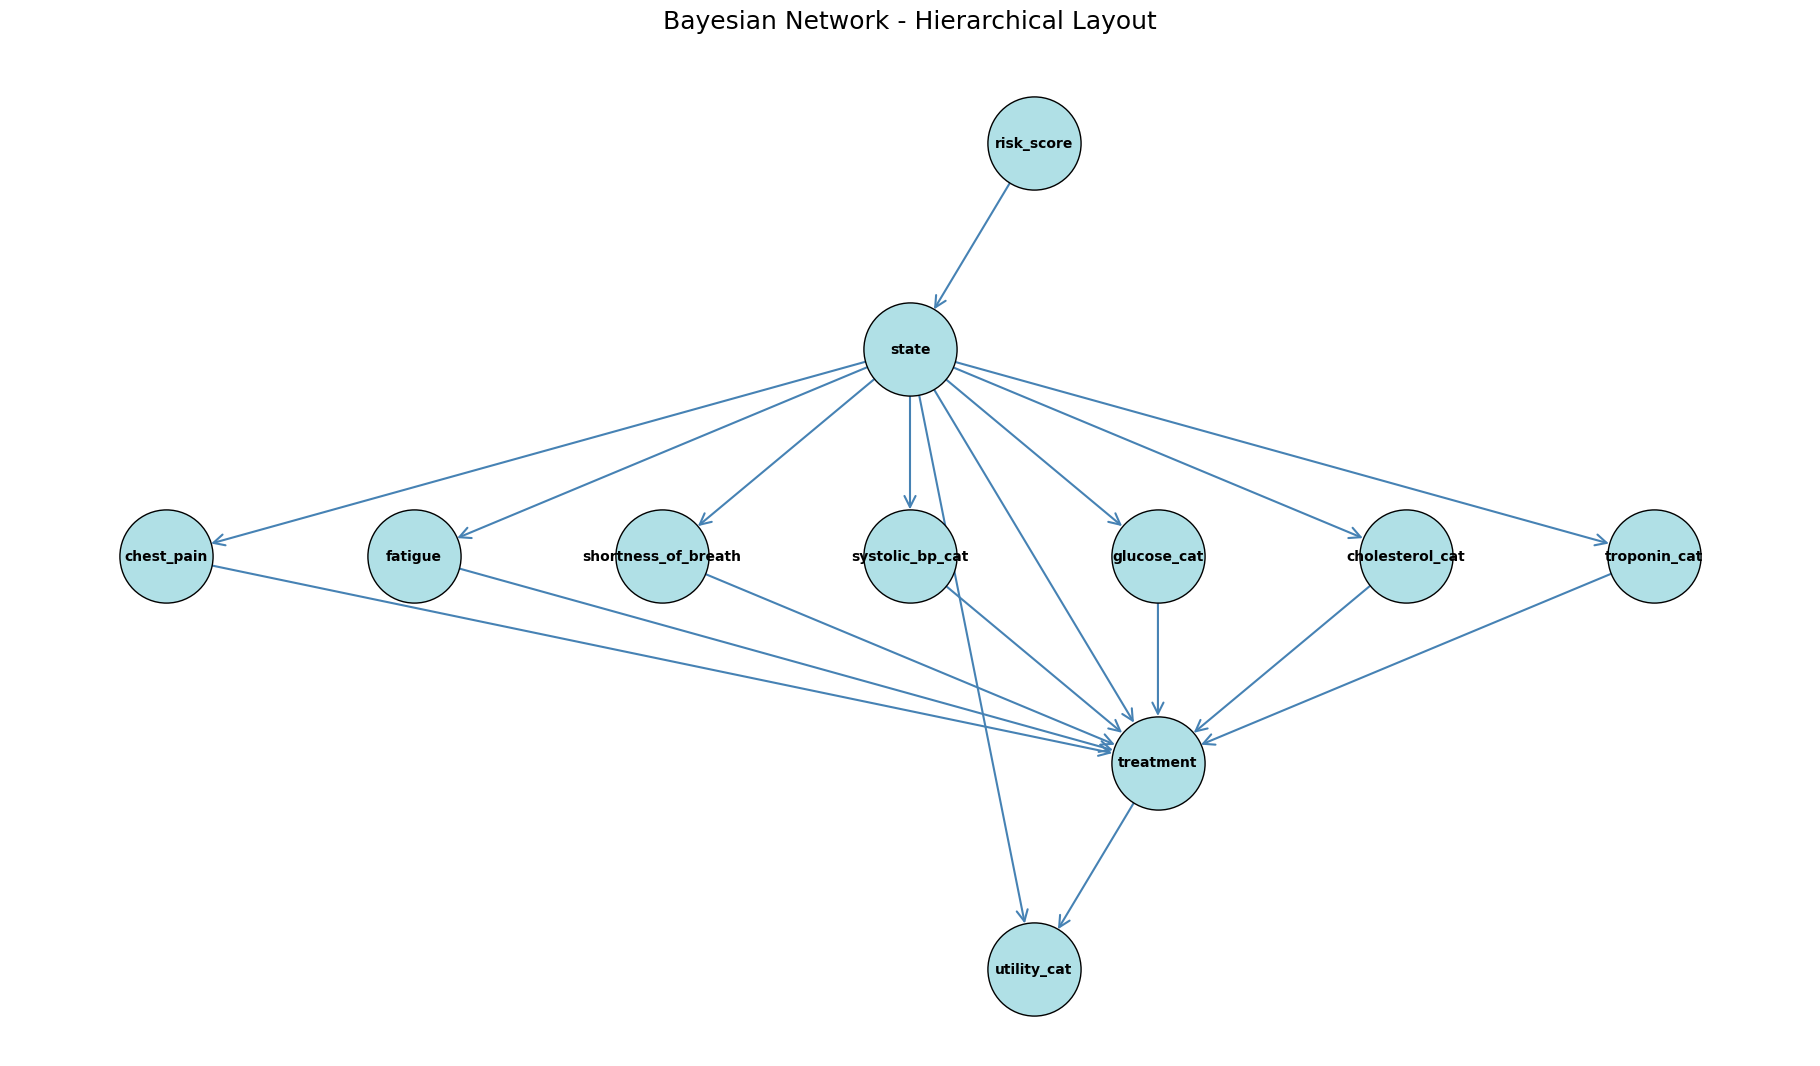

In [11]:
# Create the Directed Graph (DiGraph)
G = nx.DiGraph()
G.add_edges_from(edges)

# Manually define the hierarchical positions (x, y)
# The 'state' and 'treatment' nodes are slightly offset horizontally to separate the arrows leading to 'utility_cat'.
pos = {
    # Level 1 - Root Node (Input)
    'risk_score': (3.5, 5),

    # Level 2 - Central Intermediate Variable (Slightly left)
    'state': (3.0, 4),

    # Level 3 - Clinical Variables/Symptoms
    'chest_pain': (0, 3),
    'fatigue': (1, 3),
    'shortness_of_breath': (2, 3),
    'systolic_bp_cat': (3, 3),
    'glucose_cat': (4, 3),
    'cholesterol_cat': (5, 3),
    'troponin_cat': (6, 3),

    # Level 4 - Treatment (Slightly right)
    'treatment': (4.0, 2),

    # Level 5 - Outcome/Utility (Center)
    'utility_cat': (3.5, 1)
}


#  Draw the Graph
plt.figure(figsize=(18, 10))

# Drawing parameters
node_size = 4500
node_color = "#B0E0E6" # Powder Blue
edge_color = '#4682B4' # Steel Blue
font_size = 10

nx.draw(
    G, pos,
    with_labels=True,
    node_size=node_size,
    node_color=node_color,
    font_size=font_size,
    font_weight="bold",
    font_color="black",
    arrowstyle="->",
    arrowsize=20,
    edge_color=edge_color,
    edgecolors="black",
    width=1.5
)
plt.title("Bayesian Network - Hierarchical Layout", fontsize=18, pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

In [12]:
variables_BN=['state', 'treatment', 'chest_pain', 'fatigue',
       'shortness_of_breath', 'risk_score', 'systolic_bp_cat', 'cholesterol_cat', 'glucose_cat', 'troponin_cat',
       'utility_cat']
df_BN=df_discrete[variables_BN]

In [13]:
cpds = []
for node in df_BN.columns:
    parents = [u for u,v in edges if v == node]
    states, parents_states, mat = estimate_cpt(df_BN, node, parents)
    if parents:
        evidence_card = [len(ps) for ps in parents_states]
        cpd = TabularCPD(
            variable=node,
            variable_card=len(states),
            values=mat.tolist(),
            evidence=parents,
            evidence_card=evidence_card,
            state_names={node: states, **{p:ps for p,ps in zip(parents, parents_states)}}
        )
    else:
        cpd = TabularCPD(
            variable=node,
            variable_card=len(states),
            values=mat.reshape(len(states),1).tolist(),
            state_names={node: states}
        )
    cpds.append(cpd)

model.add_cpds(*cpds)
assert model.check_model()

## 4.&nbsp;Exact Inference - Variable Elimination and Belief Propagation

This section performs exact inference on the Bayesian Network to calculate the precise posterior probability distributions for the query variables. Both Variable Elimination (VE) and Belief Propagation (BP) algorithms are utilized to derive these probability values based on the provided evidence.

Since the underlying structure of this Bayesian Network is a polytree (a singly connected graph, meaning it contains no undirected cycles/loops), we expect the results from the Variable Elimination (VE) algorithm and the Belief Propagation (BP) algorithm to be identical.

###4.1. P(state | chest_pain=1, fatigue=1)

In [14]:
# Check that CPDs are correctly loaded
print("Model CPDs:")
for cpd in model.get_cpds():
    print(cpd)
    print("")

# Initialize inferences
ve = VariableElimination(model)
bp = BeliefPropagation(model)

# ------------------------------

# a) Diagnosis
# P(state | chest_pain=1, fatigue=1)

print("\n=== (a) Diagnosis: P(state | chest_pain=1, fatigue=1) ===")

q_a_ve = ve.query(variables=['state'], evidence={'chest_pain': 1, 'fatigue': 1})
q_a_bp = bp.query(variables=['state'], evidence={'chest_pain': 1, 'fatigue': 1})

print("\nVariable Elimination result:")
print(q_a_ve)
print("\nBelief Propagation result:")
print(q_a_bp)

Model CPDs:
+-----------------+-----+--------------------+
| risk_score      | ... | risk_score(5)      |
+-----------------+-----+--------------------+
| state(Advanced) | ... | 0.1079136690647482 |
+-----------------+-----+--------------------+
| state(Early)    | ... | 0.381294964028777  |
+-----------------+-----+--------------------+
| state(Healthy)  | ... | 0.5107913669064749 |
+-----------------+-----+--------------------+

+----------------------+-----+--------------------------+
| state                | ... | state(Healthy)           |
+----------------------+-----+--------------------------+
| chest_pain           | ... | chest_pain(1.0)          |
+----------------------+-----+--------------------------+
| fatigue              | ... | fatigue(1.0)             |
+----------------------+-----+--------------------------+
| shortness_of_breath  | ... | shortness_of_breath(1.0) |
+----------------------+-----+--------------------------+
| systolic_bp_cat      | ... | systolic_bp

The results from both algorithms are numerically identical, which confirms that the network is acyclic and both inferences engines have reached the exact same posterior distributions.

* Diagnosis➞$P(\text{state}|\text{chest_pain, fatigue})$:
| State    | Posterior Probability |
| -------- | --------------------- |
| Advanced | 0.3906                |
| Early    | 0.5282                |
| Healthy  | 0.0812                |

  Given that the patient presents chest pain and fatigue, the model estimates:

  52.8% chance that the disease is in an Early stage;

  39.1% chance it’s in an Advanced stage;

  8.1% chance that the patient is Healthy.

  This makes sense clinically: these two symptoms are more likely to occur in individuals who already have some degree of illness rather than in healthy subjects.

###4.2. P(treatment | chest_pain=1, fatigue=1)

In [15]:
# b) Treatment
# P(treatment | chest_pain=1, fatigue=1)

print("\n=== (b) Treatment: P(treatment | chest_pain=1, fatigue=1) ===")

q_b_ve = ve.query(variables=['treatment'], evidence={'chest_pain': 1, 'fatigue': 1})
q_b_bp = bp.query(variables=['treatment'], evidence={'chest_pain': 1, 'fatigue': 1})

print("\nVariable Elimination result:")
print(q_b_ve)
print("\nBelief Propagation result:")
print(q_b_bp)



=== (b) Treatment: P(treatment | chest_pain=1, fatigue=1) ===

Variable Elimination result:
+----------------------+------------------+
| treatment            |   phi(treatment) |
+======================+==================+
| treatment(DrugA)     |           0.4143 |
+----------------------+------------------+
| treatment(DrugB)     |           0.3263 |
+----------------------+------------------+
| treatment(Lifestyle) |           0.1291 |
+----------------------+------------------+
| treatment(None)      |           0.1303 |
+----------------------+------------------+

Belief Propagation result:
+----------------------+------------------+
| treatment            |   phi(treatment) |
+======================+==================+
| treatment(DrugA)     |           0.4143 |
+----------------------+------------------+
| treatment(DrugB)     |           0.3263 |
+----------------------+------------------+
| treatment(Lifestyle) |           0.1291 |
+----------------------+------------------+

* Treatment➞$P(\text{treatment}|\text{chest_pain, fatigue})$:
| Treatment | Posterior Probability |
| --------- | --------------------- |
| DrugA     | 0.4143                |
| DrugB     | 0.3263                |
| Lifestyle | 0.1291                |
| None      | 0.1303                |

  The most likely treatment prescribed for patients with these symptoms is DrugA (41.4%), followed by DrugB (32.6%).

  This suggests that the model associates chest pain and fatigue with pharmacological interventions rather than conservative or no treatment.


###4.3. P(utility | risk_score=4, treatment='DrugA')

In [16]:
# c) Outcome
# P(utility_cat | risk_score=4, treatment='DrugA')

print("\n=== (c) Outcome: P(utility_cat | risk_score=4, treatment='DrugA') ===")

q_c_ve = ve.query(variables=['utility_cat'], evidence={'risk_score': 4, 'treatment': 'DrugA'})
q_c_bp = bp.query(variables=['utility_cat'], evidence={'risk_score': 4, 'treatment': 'DrugA'})

print("\nVariable Elimination result:")
print(q_c_ve)
print("\nBelief Propagation result:")
print(q_c_bp)


=== (c) Outcome: P(utility_cat | risk_score=4, treatment='DrugA') ===

Variable Elimination result:
+---------------------+--------------------+
| utility_cat         |   phi(utility_cat) |
+=====================+====================+
| utility_cat(High)   |             0.1756 |
+---------------------+--------------------+
| utility_cat(Low)    |             0.1651 |
+---------------------+--------------------+
| utility_cat(Medium) |             0.6593 |
+---------------------+--------------------+

Belief Propagation result:
+---------------------+--------------------+
| utility_cat         |   phi(utility_cat) |
+=====================+====================+
| utility_cat(High)   |             0.1756 |
+---------------------+--------------------+
| utility_cat(Low)    |             0.1651 |
+---------------------+--------------------+
| utility_cat(Medium) |             0.6593 |
+---------------------+--------------------+


* Outcome➞$P(\text{utility}|\text{risk_4}, \text{DrugA})$:
| Utility Category | Posterior Probability |
| ---------------- | --------------------- |
| High             | 0.1756                |
| Medium           | 0.6593                |
| Low              | 0.1651                |

  For a patient with risk_score = 4 who receives DrugA:

  There’s about a 66% chance of a medium utility;

  17.6% chance of a high (good) outcome;

  16.5% chance of a low (poor) outcome.

  This indicates that while DrugA provides some improvement, it does not guarantee excellent outcomes for higher-risk patients.

###4.4. P(state | systolic_bp=1, cholesterol=1)

This query is used to infer the patient’s health state based on their systolic blood pressure and cholesterol levels.

Since we previously performed the same analysis using chest pain and fatigue as evidence, comparing the two queries allows us to assess which symptoms or risk factors have a stronger influence on the predicted disease state.

In [35]:
# d)
# P(state | systolic_bp=1, cholesterol=1)

print("\n=== (d) Diagnosis: P(state | systolic_bp='High', cholesterol='High') ===")

q_d_ve = ve.query(variables=['state'], evidence={'systolic_bp_cat': 'High', 'cholesterol_cat': 'High'})
q_d_bp = bp.query(variables=['state'], evidence={'systolic_bp_cat': 'High', 'cholesterol_cat': 'High'})

print("\nVariable Elimination result:")
print(q_d_ve)
print("\nBelief Propagation result:")
print(q_d_bp)


=== (d) Diagnosis: P(state | systolic_bp=1, cholesterol=1) ===

Variable Elimination result:
+-----------------+--------------+
| state           |   phi(state) |
+=================+==============+
| state(Advanced) |       0.1415 |
+-----------------+--------------+
| state(Early)    |       0.5870 |
+-----------------+--------------+
| state(Healthy)  |       0.2715 |
+-----------------+--------------+

Belief Propagation result:
+-----------------+--------------+
| state           |   phi(state) |
+=================+==============+
| state(Advanced) |       0.1415 |
+-----------------+--------------+
| state(Early)    |       0.5870 |
+-----------------+--------------+
| state(Healthy)  |       0.2715 |
+-----------------+--------------+


* Diagnosis➞$P(\text{state}|\text{systolic_bp, cholesterol})$:
| State    | Posterior Probability |
| -------- | --------------------- |
| Advanced | 0.1415                |
| Early    | 0.5870                |
| Healthy  | 0.2715                |

  Given high values for both systolic blood pressure and cholesterol, the model infers that the most likely condition is an Early disease stage (≈59%), followed by Healthy (≈27%) and Advanced (≈14%).
  
  This suggests that while these two clinical markers are significant indicators of risk, they are more closely associated with early disease onset rather than with fully advanced disease.


###4.5. P(treatment | state='Healthy', shortness_of_breath=1)

This query aims to determine whether patients who exhibit a symptom (e.g. shortness of breath) but are classified as Healthy are still likely to receive drug treatment.

In [36]:
# e)
# P(treatment | state='Healthy', shortness_of_breath=1)

print("\n=== (e) Treatment: P(treatment | state='Healthy', shortness_of_breath=1) ===")

q_e_ve = ve.query(variables=['treatment'], evidence={'state': 'Healthy', 'troponin_cat': 'High'})
q_e_bp = bp.query(variables=['treatment'], evidence={'state': 'Healthy', 'troponin_cat': 'High'})

print("\nVariable Elimination result:")
print(q_e_ve)
print("\nBelief Propagation result:")
print(q_e_bp)



=== (e) Treatment: P(treatment | state='Healthy', shortness_of_breath=1) ===

Variable Elimination result:
+----------------------+------------------+
| treatment            |   phi(treatment) |
+======================+==================+
| treatment(DrugA)     |           0.0653 |
+----------------------+------------------+
| treatment(DrugB)     |           0.0167 |
+----------------------+------------------+
| treatment(Lifestyle) |           0.0963 |
+----------------------+------------------+
| treatment(None)      |           0.8217 |
+----------------------+------------------+

Belief Propagation result:
+----------------------+------------------+
| treatment            |   phi(treatment) |
+======================+==================+
| treatment(DrugA)     |           0.0653 |
+----------------------+------------------+
| treatment(DrugB)     |           0.0167 |
+----------------------+------------------+
| treatment(Lifestyle) |           0.0963 |
+----------------------+----

* Treatment➞$P(\text{treatment}|\text{healthy, shortness_of_breath})$:
| Treatment | Posterior Probability |
| --------- | --------------------- |
| DrugA     | 0.0653                |
| DrugB     | 0.0167                |
| Lifestyle | 0.0963                |
| None      | 0.8217                |


  For a patient who is clinically healthy but reports shortness of breath, the model strongly favors no treatment (≈82%).

  This reflects that the variable state has a dominant influence on treatment decisions: even if mild symptoms occur, being classified as Healthy substantially reduces the probability of medical intervention.

###4.6. P(utility | risk_score=4, treatment='DrugB')

Since we have already computed the posterior distribution for DrugA, it is important to perform the same query for DrugB in order to compare the expected outcomes between the two treatments.

In [37]:
# f)
# P(utility | risk_score'= 4, treatment='DrugB')

print("\n=== (f) Utility: P(utility | risk_score=4, treatment='DrugB) ===")

q_f_ve = ve.query(variables=['utility_cat'], evidence={'risk_score': 4, 'treatment': 'DrugB'})
q_f_bp = bp.query(variables=['utility_cat'], evidence={'risk_score': 4, 'treatment': 'DrugB'})

print("\nVariable Elimination result:")
print(q_f_ve)
print("\nBelief Propagation result:")
print(q_f_bp)



=== (f) Utility: P(utility | risk_score=4, treatment='DrugB) ===

Variable Elimination result:
+---------------------+--------------------+
| utility_cat         |   phi(utility_cat) |
+=====================+====================+
| utility_cat(High)   |             0.0089 |
+---------------------+--------------------+
| utility_cat(Low)    |             0.2599 |
+---------------------+--------------------+
| utility_cat(Medium) |             0.7312 |
+---------------------+--------------------+

Belief Propagation result:
+---------------------+--------------------+
| utility_cat         |   phi(utility_cat) |
+=====================+====================+
| utility_cat(High)   |             0.0089 |
+---------------------+--------------------+
| utility_cat(Low)    |             0.2599 |
+---------------------+--------------------+
| utility_cat(Medium) |             0.7312 |
+---------------------+--------------------+


* Outcome➞$P(\text{utility}|\text{risk_4}, \text{DrugB})$:
| Utility Category | Posterior Probability |
| ---------------- | --------------------- |
| High             | 0.0089                |
| Medium           | 0.7312                |
| Low              | 0.2599                |

  For a patient with risk_score = 4 who receives DrugB:

  There’s about a 73% chance of a medium utility outcome;

  A 26% chance of a low (poor) outcome;

  And only a 0.9% chance of a high (good) outcome.

  This suggests that, DrugB provides limited benefit for patients with elevated risk scores and, compared with DrugA, it appears less effective.